In [1]:
#1st step - Install all required libraries
"""
!pip install --upgrade pandas
!pip install --upgrade numpy
!pip install --upgrade matplotlib
!pip install --upgrade seaborn
!pip install --upgrade scipy
!pip install --upgrade tensorflow
!pip install --upgrade keras
!pip install --upgrade sklearn
"""

'\n!pip install --upgrade pandas\n!pip install --upgrade numpy\n!pip install --upgrade matplotlib\n!pip install --upgrade seaborn\n!pip install --upgrade scipy\n!pip install --upgrade tensorflow\n!pip install --upgrade keras\n!pip install --upgrade sklearn\n'

In [1]:
import scipy.signal as sci
import scipy.stats as scp
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from math import sqrt
import math
import os
import json
import time
import seaborn as sns
from core.data_processor import DataLoader
from core.model import Model
import datetime

Using TensorFlow backend.


In [3]:
#Parameters 
class Parameters(object):
    pass

param = Parameters()
param.tickSize = 0.5 #tick size is 0.5 GBp i.e. 0.005 GBP

param.fileDirectory = './intraday/'
param.trade_InSampleFile = 'trade_in.csv'
param.quote_InSampleFile = 'quote_in.csv'

param.trade_OutSampleFile = 'trade_out.csv'
param.quote_OutSampleFile = 'quote_out.csv'

In [4]:
param.fileDirectory

'./intraday/'

In [5]:
#Identify future mid prices - 30 seconds duration
def IdentifyFutureMidPrices(df, predictionDuration = 30):
    futDat = df[['datetime', 'mid']].rename(columns={'mid':'futMid'})
    futDat['datetime'] = futDat['datetime'] - pd.offsets.timedelta(seconds=int(predictionDuration))
    return pd.merge_asof(df, futDat, on='datetime', direction='backward')

def ReadCSV(file):
    print('Loading file - ' + file)
    df = pd.read_csv(file)
    df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%dD%H:%M:%S.%f")
    return df

#Load data
def LoadData(path, tradeFile, quoteFile):
    tradeFile = os.path.join(path, tradeFile)
    quoteFile = os.path.join(path, quoteFile)

    trade_df = ReadCSV(tradeFile)
    quote_df = ReadCSV(quoteFile)
    
    quote_df['mid'] = 0.5*(quote_df['bid'].copy() + quote_df['ask'].copy())
    quote_df['midChangeGroup'] = quote_df['mid'].diff().ne(0).cumsum()
    quote_df = IdentifyFutureMidPrices(quote_df)
    return trade_df, quote_df

#Evaluation function
#df should contain columns - datetime, sym, bsize, bid, ask, asize, predMid (model predicted mid-price)
#Function to evaluate results and return RMS if needed
def RMS(df, ret = False):
    df = df.groupby(['midChangeGroup']).first().reset_index()
    tmp = df.dropna(subset=['predMid', 'futMid'])
    rms = sqrt(mean_squared_error(tmp['futMid'], tmp['predMid']))
    predCount = len(tmp['predMid'])
    print('RMS = %.4f. #Predictions = %s' % (rms, predCount))
    if ret == True:
        return rms

In [6]:
df_tradein,df_quotein   = LoadData(param.fileDirectory,param.trade_InSampleFile,param.quote_InSampleFile)
df_tradeout,df_quoteout = LoadData(param.fileDirectory,param.trade_OutSampleFile,param.quote_OutSampleFile)

Loading file - ./intraday/trade_in.csv
Loading file - ./intraday/quote_in.csv
Loading file - ./intraday/trade_out.csv
Loading file - ./intraday/quote_out.csv


In [7]:
df_quotein.head()

,datetime,sym,bsize,bid,ask,asize,mid,midChangeGroup,futMid
0,2018-02-01 05:00:09.686,TEST.L,11850,4800.0,5100.0,8450,4950.0,1,4950.0
1,2018-02-01 07:50:00.048,TEST.L,11850,4800.0,4884.0,237,4842.0,2,4842.0
2,2018-02-01 07:50:00.077,TEST.L,11965,4800.0,4884.0,237,4842.0,2,4842.0
3,2018-02-01 07:50:00.078,TEST.L,12084,4800.0,4884.0,237,4842.0,2,4842.0
4,2018-02-01 07:50:00.095,TEST.L,12384,4800.0,4884.0,237,4842.0,2,4842.0


In [8]:
df_tradein.head()

,datetime,sym,price,size
0,2018-02-01 07:50:00.077,TEST.L,4884.0,115
1,2018-02-01 07:50:00.078,TEST.L,4884.0,234
2,2018-02-01 07:50:00.095,TEST.L,4884.0,534
3,2018-02-01 07:50:00.177,TEST.L,4884.0,534
4,2018-02-01 07:50:00.179,TEST.L,4884.0,534


In [9]:
#Feature Engineering  
def feature_engg(df_quote,df_trade):
    df1 = df_quote[['datetime', 'bid', 'ask', 'bsize', 'asize','midChangeGroup','futMid','mid']]
    df2 = df_trade[['datetime', 'price', 'size']]

    # To find when the market opens 
    trade_rate = df2['size'].shift(-1)-df2['size']
    peaks = sci.find_peaks(x=-trade_rate, threshold=10000)[0]
    start = peaks[0]+1

    # Discarding data before market opening
    trade = df2[start:len(df2)]
    quote = df1[df1['datetime']>=df2.loc[start,'datetime']]
    
    # Finding change in bid_size and ask_size to spot sell orders and buy orders
    quote['b_change'] = quote['bsize']-quote['bsize'].shift(1)
    quote['a_change'] = quote['asize']-quote['asize'].shift(1)
    
    # Finding arrival rate
    quote['del_t'] = (quote['datetime'] - quote['datetime'].shift(1)).dt.total_seconds()
    quote.loc[quote['del_t'] == 0, 'del_t'] = np.nan
    quote['del_t'].fillna(method = 'ffill', inplace = True)
    quote['order_change'] = 0
    quote.loc[quote['b_change'] != 0, 'order_change'] = quote['b_change']
    quote.loc[quote['a_change'] != 0, 'order_change'] = quote['a_change']
    
    # VARIABLE 1 - arrival_rate = d(order_size)/(dt)
    quote['arrival_rate'] = quote['order_change']/quote['del_t']
    
    # Create a column 'merger' to match trade with quote based on trade price matching 
    # either the ask price or bid price (decided by change in bsize or asize) 
    quote['merger'] = quote['datetime']
    quote.reset_index(drop = True, inplace = True)
    quote.loc[quote[quote['b_change'] != 0].drop(0, axis = 0).index, 'merger'] = quote.loc[quote['b_change'] != 0, 'datetime'].drop(0, axis = 0).apply(str).values + '-' + quote.loc[quote['b_change'].shift(-1) != 0, 'bid'].apply(str).values[:-1]
    quote.loc[quote[quote['a_change'] != 0].drop(0, axis = 0).index, 'merger'] = quote.loc[quote['a_change'] != 0, 'datetime'].drop(0, axis = 0).apply(str).values + '-' + quote.loc[quote['a_change'].shift(-1) != 0, 'ask'].apply(str).values[:-1]

    # Cumulative count label to handle multiple trades and quotes at the same time instant
    quote['cum_count'] = quote.groupby('merger').cumcount()
    quote['merger'] = quote['cum_count'].apply(str) + ':' + quote['merger'].apply(str)

    # Adding cumulative count to merger to create unique values in merge column'
    trade['merger'] = trade['datetime'].apply(str) + '-' + trade['price'].apply(str)
    trade['cum_count'] = trade.groupby('merger').cumcount()
    trade['merger'] = trade['cum_count'].apply(str) + ':' + trade['merger'].apply(str)

    # Drop unnecessary column
    trade.drop('cum_count', axis = 1, inplace = True)
    quote.drop('cum_count', axis = 1, inplace = True)

    # Merge Quote and Trade based on the 'merger' column
    df = quote.merge(trade, how = 'left', on='merger')
    
    # Drop unnecessary columns
    df.drop(['datetime_y', 'a_change', 'b_change', 'merger', 'del_t', 'order_change'], inplace = True, axis = 1)

    # Finding accumalated imbalance
    df.set_index('datetime_x', inplace = True)
    df['Accum_Bid'] = df.loc[:,['bsize']].rolling('1s').sum()
    df['Accum_Ask'] = df.loc[:,['asize']].rolling('1s').sum()
    
    # VARIABLE 2 - integrated imbalance = (total bsize - total asize)/(total bsize + total asize) in 1s
    df['imbalance'] = (df['Accum_Bid'] - df['Accum_Ask'])/(df['Accum_Bid'] + df['Accum_Ask'])
    df.reset_index(inplace = True)
    
    # Identifying buy/sell Trades and no Trades
    # VARIABLE 3 - Trade = +1 (Buy), -1 (Sell), 0 (No Trade)
    df['Trade'] = 0
    df.loc[df['price'] == df['ask'].shift(1), 'Trade'] = 1
    df.loc[df['price'] == df['bid'].shift(1), 'Trade'] = -1

    # Trade size and Trade Price resolving NAs
    # VARIABLE 4 - size of Trade
    df['size'].fillna(0, inplace = True)
    
    # VARIABLE 5 - price of Trade
    df['price'].fillna(0, inplace = True)
    
    # VARIABLE 6 - spread = bid - ask
    df['spread'] = df['ask'] - df['bid']
    
    # Drop unnecessary columns
    df.drop(['bsize', 'asize', 'ask', 'bid', 'Accum_Bid', 'Accum_Ask'], inplace = True, axis = 1)
    
    return df.dropna().reset_index(drop = True)

In [10]:
df = feature_engg(df_quotein,df_tradein)

In [11]:
df.head()

,datetime_x,midChangeGroup,futMid,mid,arrival_rate,price,size,imbalance,Trade,spread
0,2018-02-01 08:00:18.248,7,4839.5,4832.75,458000.0,0.0,0.0,-0.273973,0,8.5
1,2018-02-01 08:00:18.248,8,4839.5,4834.50,-90500.0,0.0,0.0,-0.509378,0,5.0
2,2018-02-01 08:00:18.248,8,4839.5,4834.50,15500.0,0.0,0.0,-0.607748,0,5.0
3,2018-02-01 08:00:18.248,8,4839.5,4834.50,7500.0,0.0,0.0,-0.659197,0,5.0
4,2018-02-01 08:00:18.249,8,4839.5,4834.50,-31000.0,0.0,0.0,-0.701681,0,5.0


In [24]:
len(df)

1672754

In [12]:
"Introduces smooth Labeling "
def target_creator(df,lag=50,alpha=1):
    df['target'] = np.NaN
    for i in range(lag-1,len(df)-lag):
        m_minus = (1/lag) * df.mid.iloc[i+1-lag:i+1].sum()
        m_plus =  (1/lag) * df.mid.iloc[i+1:i+1+lag].sum()
        if m_minus>m_plus*(1+alpha):
            l = -1
        elif m_minus<m_plus*(1-alpha):
            l=1
        else: 
            l=0
        df['target'].iloc[i] = l
    return df

In [ ]:
df=target_creator(df)

In [20]:
# Normalizing the feature vectors
def normalization(df,columns):
    A = df.loc[:,columns].copy()
    A.dropna(inplace = True)
    mean = A.loc[:,columns].mean()
    std = A.loc[:,columns].std()
    A.loc[:,columns] = (A.loc[:,columns] - mean)/std
    return [A, mean, std]

def norm_zero(df,columns):    
    B = df.loc[:,columns].copy().replace(0,np.NaN)
    mean = B.mean()
    std = B.std()
    B = (B - mean)/std
    B = B.replace(np.NaN,0)
    return [B,mean,std]
def Normalizing_whole(df):
    # Normalizing only non classification columns
    df_std = df.copy()
    columns = ['imbalance', 'spread', 'arrival_rate','mid']
    [df_std[columns], mean, std] = normalization(df, columns)
    df_std['Trade'] = df['Trade']
    [df_std[['price','size']],mean_rest,std_rest]= norm_zero(df,['price','size'])

    Mean = pd.concat([mean,mean_rest])
    Std = pd.concat([std,std_rest])
    df_std.reset_index(inplace = True, drop = True)
    return [df_std,Mean,Std]

In [21]:
[df_std,Mean,Std] = Normalizing_whole(df)
# Saving as CSV
print('Saving as CSV...')
# df_std.to_csv('merged.csv')
df_std.info()

Saving as CSV...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1672754 entries, 0 to 1672753
Data columns (total 10 columns):
datetime_x        1672754 non-null datetime64[ns]
midChangeGroup    1672754 non-null int64
futMid            1672754 non-null float64
mid               1672754 non-null float64
arrival_rate      1672754 non-null float64
price             1672754 non-null float64
size              1672754 non-null float64
imbalance         1672754 non-null float64
Trade             1672754 non-null int64
spread            1672754 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 127.6 MB


In [22]:
df_std.head()

,datetime_x,midChangeGroup,futMid,mid,arrival_rate,price,size,imbalance,Trade,spread
0,2018-02-01 08:00:18.248,7,4839.5,1.964891,2.148942,0.0,0.0,-0.876897,0,3.477824
1,2018-02-01 08:00:18.248,8,4839.5,1.978741,-0.429102,0.0,0.0,-1.618022,0,1.823382
2,2018-02-01 08:00:18.248,8,4839.5,1.978741,0.069116,0.0,0.0,-1.927718,0,1.823382
3,2018-02-01 08:00:18.248,8,4839.5,1.978741,0.031515,0.0,0.0,-2.089693,0,1.823382
4,2018-02-01 08:00:18.249,8,4839.5,1.978741,-0.149442,0.0,0.0,-2.223445,0,1.823382


In [23]:
print('Mean : \n', Mean, '\n\nStd : \n', Std)
df_std.head()

('Mean : \n', imbalance          0.004559
spread             1.142605
arrival_rate     794.949975
mid             4584.481069
price           4573.008394
size             178.785205
dtype: float64, '\n\nStd : \n', imbalance            0.317633
spread               2.115517
arrival_rate    212758.241086
mid                126.352507
price              126.422281
size              8293.698866
dtype: float64)


,datetime_x,midChangeGroup,futMid,mid,arrival_rate,price,size,imbalance,Trade,spread
0,2018-02-01 08:00:18.248,7,4839.5,1.964891,2.148942,0.0,0.0,-0.876897,0,3.477824
1,2018-02-01 08:00:18.248,8,4839.5,1.978741,-0.429102,0.0,0.0,-1.618022,0,1.823382
2,2018-02-01 08:00:18.248,8,4839.5,1.978741,0.069116,0.0,0.0,-1.927718,0,1.823382
3,2018-02-01 08:00:18.248,8,4839.5,1.978741,0.031515,0.0,0.0,-2.089693,0,1.823382
4,2018-02-01 08:00:18.249,8,4839.5,1.978741,-0.149442,0.0,0.0,-2.223445,0,1.823382


In [ ]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

In [ ]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
        # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

History = 0
RMS = 121.0331. #Predictions = 370691
History =  1
RMS = 121.0154. #Predictions = 370689
History =  2
RMS = 120.9977. #Predictions = 370688
History =  3
RMS = 120.9929. #Predictions = 370688
History =  4
RMS = 120.9905. #Predictions = 370687
History =  5
RMS = 120.9882. #Predictions = 370685
History =  6
RMS = 120.9796. #Predictions = 370684
History =  7
RMS = 120.9762. #Predictions = 370682
History =  8
RMS = 120.9679. #Predictions = 370680
History =  9
RMS = 120.9605. #Predictions = 370678
History =  10
RMS = 120.9533. #Predictions = 370676
History =  11
RMS = 120.9487. #Predictions = 370675
History =  12
RMS = 120.9433. #Predictions = 370674
History =  13
RMS = 120.9351. #Predictions = 370672
History =  14
RMS = 120.9292. #Predictions = 370671
History =  15
RMS = 120.9198. #Predictions = 370670


<IPython.core.display.Javascript object>


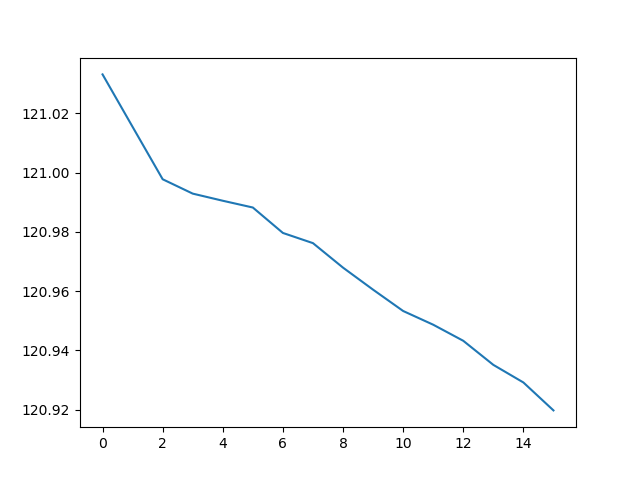

In [16]:
# Using a simple machine learning algorithm to iteratively try larger
# histories till the RMS doesn't improve significantly

########################################################################
# RUN ONLY ONCE TO FIND OUT HOW MUCH HISTORY IS NEEDED. 
# NO NEED TO RUN DURING EVERY TRAINING
########################################################################

max_history = 15
rms_set = []
lm = LinearRegression()

inputs = ['arrival_rate', 'price', 'size', 'imbalance', 'Trade', 'spread']
X = df.loc[:, inputs].reset_index(drop = True)
Y = df.loc[:,'mid'].reset_index(drop = True)

lm.fit(X, Y)

data_frame = pd.DataFrame()
data_frame['predMid'] = lm.predict(X)
data_frame['futMid'] = Y
data_frame['midChangeGroup'] = df.loc[:, 'midChangeGroup']

print('History = 0')
rms_set.append(RMS(data_frame, True))
    
for history in range(1, max_history+1):
    new_X = df.loc[history:, inputs].reset_index(drop = True)
    data_frame = pd.DataFrame()
    data_frame['midChangeGroup'] = df.loc[history:, 'midChangeGroup']

    X = new_X.join(X, rsuffix=history).dropna()
    Y = df.loc[history:,'mid'].reset_index(drop = True)
    data_frame['futMid'] = Y
    
    lm.fit(X, Y)
    data_frame['predMid'] = lm.predict(X)
    
    print('History = ', history)
    rms_set.append(RMS(data_frame, True))

plt.plot(rms_set)
plt.show()

In [6]:
# LSTM model in ./core/model.py
# config contains all required parameters for the model 

def model_run():
    configs = json.load(open('config.json', 'r'))
    if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

    data = DataLoader(
        configs['data']['filename'],
        configs['data']['train_test_split'],
        configs['data']['columns']
    )

    model = Model()
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    '''
        # in-memory training
        model.train(
            x,
            y,
            epochs = configs['training']['epochs'],
            batch_size = configs['training']['batch_size'],
            save_dir = configs['model']['save_dir']
        )
    '''
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )

    x_test, y_test = data.get_test_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )
# model_run()

[Model] Model Compiled
Time taken: 0:00:01.953746
[Model] Training Started
[Model] 100 epochs, 256 batch size, 5227.0 batches per epoch
Epoch 1/100
5227/5227 [==============================] - 14484s 3s/step - loss: 0.0072
Epoch 2/100
5227/5227 [==============================] - 14367s 3s/step - loss: 0.0061
Epoch 3/100
2037/5227 [==========>...................] - ETA: 3:26:58 - loss: 0.0228

KeyboardInterrupt: 

In [14]:
#Loading saved model
from keras.models import load_model

# returns a compiled model
# identical to the previous one
#To run if not trained the model
configs = json.load(open('config.json', 'r'))
model = Model()
model.build_model(configs)
model.load_model('./saved_models/12012019-110735-e10.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 49, 20)            2240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 49, 30)            6120      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 15,711
Trainable params: 15,711
Non-trainable params: 0
_________________________________________________________________
[Model

In [24]:
df_test = feature_engg(df_quoteout,df_tradeout)

# Normalise test data
def norm_test(df_test):
    columns = list(Mean.index)
    df_test.loc[:,columns] = (df_test.loc[:,columns] - Mean)/Std
    return df_test

# Normalizing test data using the mean and std obtained from the training data
df_std = norm_test(df_test)
df_std.reset_index(inplace = True, drop = True)

# Saving as CSV
print('Saving as CSV...')
# df_std.to_csv('merged_test.csv')
df_std.info()

Saving as CSV...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207256 entries, 0 to 207255
Data columns (total 10 columns):
datetime_x        207256 non-null datetime64[ns]
midChangeGroup    207256 non-null int64
futMid            207256 non-null float64
mid               207256 non-null float64
arrival_rate      207256 non-null float64
price             207256 non-null float64
size              207256 non-null float64
imbalance         207256 non-null float64
Trade             207256 non-null int64
spread            207256 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 15.8 MB


In [25]:
df_std.head()

,datetime_x,midChangeGroup,futMid,mid,arrival_rate,price,size,imbalance,Trade,spread
0,2018-02-14 08:00:22.710,8,4435.5,-1.224598,1.105504,-36.172488,-0.021557,2.003214,0,7.732103
1,2018-02-14 08:00:22.710,8,4435.5,-1.224598,3.690598,-36.172488,-0.021557,2.008645,0,7.732103
2,2018-02-14 08:00:22.710,9,4435.5,-1.198877,-4.299692,-36.172488,-0.021557,1.864455,0,4.659568
3,2018-02-14 08:00:22.710,9,4435.5,-1.198877,3.897405,-36.172488,-0.021557,1.878608,0,4.659568
4,2018-02-14 08:00:22.710,9,4435.5,-1.198877,3.897405,-36.172488,-0.021557,1.482022,0,4.659568


In [36]:
#For testing the data, we are testing it on cross validation data
data_test = DataLoader(configs['data']['test_filename'],0.87,configs['data']['columns'])
x_test, y_test = data_test.get_test_data(seq_len=configs['data']['sequence_length'],normalise=configs['data']['normalise'])


In [37]:
#To find the indicies where mid price changes
i_split = int(len(df_std) * 0.87)
data_test  = df_std.iloc[i_split:]
data_test=data_test.reset_index(inplace=False,drop=True)
data_test

,datetime_x,midChangeGroup,futMid,mid,arrival_rate,price,size,imbalance,Trade,spread
0,2018-02-14 15:43:04.292,47630,4448.25,-1.062354,0.842294,-36.172488,-0.021557,-0.001858,0,-0.303758
1,2018-02-14 15:43:04.292,47630,4448.25,-1.062354,-0.849767,-36.172488,-0.021557,-0.018167,0,-0.303758
2,2018-02-14 15:43:04.324,47630,4448.25,-1.062354,-0.006821,-0.972996,-0.019025,-0.035551,-1,-0.303758
3,2018-02-14 15:43:04.324,47631,4448.25,-1.064332,0.063682,-0.972996,-0.015649,-0.023848,-1,-0.067409
4,2018-02-14 15:43:04.324,47631,4448.25,-1.064332,-0.025768,-36.172488,-0.021557,-0.003332,0,-0.067409
5,2018-02-14 15:43:04.324,47631,4448.25,-1.064332,-0.018424,-36.172488,-0.021557,0.010651,0,-0.067409
6,2018-02-14 15:43:04.324,47632,4448.25,-1.062354,-0.057054,-36.172488,-0.021557,0.002708,0,-0.303758
7,2018-02-14 15:43:04.324,47632,4448.25,-1.062354,0.022702,-36.172488,-0.021557,-0.015969,0,-0.303758
8,2018-02-14 15:43:04.325,47632,4448.25,-1.062354,-0.849767,-36.172488,-0.021557,-0.023708,0,-0.303758
9,2018-02-14 15:43:04.342,47633,4448.25,-1.064332,0.124274,-0.972996,-0.016131,-0.004001,-1,-0.067409


In [38]:
# To get indices where mid price changes
indice_loc= data_test.midChangeGroup.drop_duplicates(keep='first', inplace=False).index
indice_loc = list(indice_loc)
indice_loc=[i for i in indice_loc if i<(indice_loc[-1]-990)]
print(len(indice_loc))

5329


In [97]:
#We have for 30 secs that is 200 time steps hence
# prediction = model.predict_at_new_mid(x_test, configs['data']['sequence_length'],200,indice_loc)


[Model] Predicting at new mid price...
Done


In [41]:
# Figure out timesteps of 30sec from that indice
def timestep(X,indice):
    start = X.loc[X['datetime_x'] <= X.loc[indice,'datetime_x']+datetime.timedelta(seconds = 30)].index[-1]
    timestep = start - indice
    return timestep

In [42]:
# Prediction depending on 30 sec timestep

prediction = []
for i in indice_loc:
    step = timestep(data_test,i)
    A = model.predict_at_new_mid_one(x_test,configs['data']['sequence_length'], step, i)
    temp = A[0][-1]
    prediction.append(temp)

[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid pr

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new m

In [43]:
df = pd.DataFrame(prediction)

In [44]:
df.head()

,0
0,-0.051931
1,-0.051932
2,-0.051931
3,-0.051932
4,-0.051931


In [51]:
df.to_csv('./saved_models/prediction_e10')

In [47]:
#Making a new data frame containg fut mid and pred mid
A  = pd.DataFrame(prediction)
A = A*Std['mid']+Mean['mid']
# B = A.iloc[:,199]
Test = data_test.futMid.iloc[indice_loc].reset_index()
Test = pd.DataFrame(Test)
Test['Predmid'] = A


In [48]:
#RMS error
rms = sqrt(mean_squared_error(Test['futMid'], Test['Predmid']))
predCount = len(Test['Predmid'])
print('RMS = %.4f. #Predictions = %s' % (rms, predCount))

RMS = 158.2724. #Predictions = 5329


In [50]:
Test

,index,futMid,Predmid
0,0,4448.25,4577.919398
1,3,4448.25,4577.919390
2,6,4448.25,4577.919402
3,9,4448.25,4577.919394
4,10,4448.25,4577.919398
5,17,4448.25,4577.812542
6,19,4448.25,4577.812542
7,23,4448.00,4556.220839
8,24,4448.00,4556.220846
9,25,4448.00,4556.220831
